$
\def\D{\Omega}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{ {\vec d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator as 
described in the PoissonBayesian example, and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \obsop u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{{\vec{x}}_1, \ldots, {\vec{x}}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The parameter-to-observable map $\iFF \,\ipar := \obsop\, u(\ipar)$ maps an initial condition $\ipar \in L^2(\D)$ to pointwise spatiotemporal observations of the concentration field $u({\vec x},t)$ through solution of the advection-diffusion equation given by

$$
\begin{split}
u_t - \kappa\Delta u + {\vec v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot {\vec{n}} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\D \subset \R^d$ ($d \in \{2, 3\}$) is a bounded domain, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta {\vec v} + \nabla q + {\vec v} \cdot \nabla {\vec v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot {\vec v} &= 0 &&\text{ in }\D,\\
{\vec v} &= {\vec g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
${\vec g} \in \R^d$ is given by 
${\vec g} = {\vec e}_2$ on the left wall of the domain, 
${\vec g}=-{\vec e}_2$ on the right wall,  and ${\vec g} = {\vec 0}$ everywhere else.

### The adjoint problem:

The adjoint problem is a final value problem, since $p$ is specified at $t = T$ rather than at $t = 0$. Thus, it is solved backwards in time, which amounts to the solution of the advection-diffusion equation

$$
\begin{aligned}
-p_t - \nabla \cdot (p {\vec v}) - \kappa \Delta p  &= -\obsop^* (\obsop u - \obs) & \quad &\text{ in } \D\times (0,T),\\
                                      p(\cdot, T) &= 0             &       &\text{ in } \D,\\ 
({ \vec{v} }p+\kappa\nabla p)\cdot {\vec{n}}            &= 0             &       &\text{ on } \partial\D\times (0,T).
\end{aligned}
$$

Then, the adjoint of the parameter to observable map $\iFF^*$ is defined by setting $\iFF^*\obs = p({\vec x}, 0).$

## 1. Load modules

In [30]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *
sys.path.append( "/home/nick/repos/hippylib/applications/ad_diff" )

# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff import TimeDependentAD, SpaceTimePointwiseStateObservation

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

from scipy.spatial import KDTree
import scipy.sparse.linalg as spla
import scipy.linalg as sla
from localpsf.bilaplacian_regularization import BiLaplacianRegularization
from localpsf.morozov_discrepancy import compute_morozov_regularization_parameter
import nalger_helper_functions as nhf

import hlibpro_python_wrapper as hpro
from localpsf.product_convolution_kernel import ProductConvolutionKernel
from localpsf.product_convolution_hmatrix import make_hmatrix_from_kernel

# Options

In [46]:
num_refinements = 2
# kappa=5.e-5 # marginally too small
# kappa=1e-3 # standard for hippylib. Quite smoothing
# kappa = 3.e-4 # Good value
# kappa = 1.e-4 # pretty small but still good
kappa = 2.e-3 # big but good
# kappa = 1.e-2

t_final        = 0.5 #1.0
dt             = .1 #0.05

gamma = 1.
# delta = 8.
# gamma = 0.25
# gamma = 0.1
# delta = 8.
prior_correlation_length = 0.25

num_checkers_x = 6
num_checkers_y = 6

rel_noise=0.01

# Mesh and finite element spaces

In [3]:
mesh = dl.Mesh("ad_20.xml")
for _ in range(num_refinements):
    mesh = dl.refine( mesh )

Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print( "Number of dofs: {0}".format( Vh.dim() ) )

dof_coords = Vh.tabulate_dof_coordinates()
dof_kdt = KDTree(dof_coords)

find_nearest_dof = lambda p: dof_kdt.query(p)[1]

Number of dofs: 7863


# Velocity field

In [4]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS # original
        

Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
XW = dl.FunctionSpace(mesh, mixed_element)

Re = dl.Constant(1e2)

g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1) # original
bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
bcs = [bc1, bc2]

vq = dl.Function(XW)
(v,q) = ufl.split(vq)
(v_test, q_test) = dl.TestFunctions (XW)

def strain(v):
    return ufl.sym(ufl.grad(v))

F = ( (2./Re)*ufl.inner(strain(v),strain(v_test))+ ufl.inner (ufl.nabla_grad(v)*v, v_test)
       - (q * ufl.div(v_test)) + ( ufl.div(v) * q_test) ) * ufl.dx

dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                     {"relative_tolerance":1e-4, "maximum_iterations":100}})

wind_velocity = v

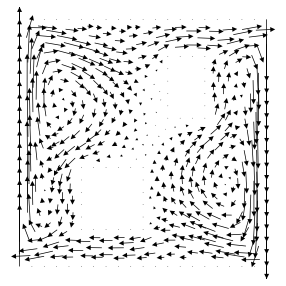

In [5]:
vh = dl.project(v,Xh)
qh = dl.project(q,Wh)

v_plot = nb.coarsen_v(vh)
plot_mesh = v_plot.function_space().mesh()
plt.figure(figsize=(5,5))
w0 = v_plot.compute_vertex_values(plot_mesh)

X = plot_mesh.coordinates()[:, 0]
Y = plot_mesh.coordinates()[:, 1]
U = w0[:plot_mesh.num_vertices()]
V = w0[plot_mesh.num_vertices():]
# C = np.sqrt(U*U+V*V)
C = np.ones(U.shape)
# pivot='middle'
pivot='tail'
plt.quiver(X,Y,U,V, C, units='x', headaxislength=7, headwidth=7, headlength=7, scale=4, pivot=pivot)

plt.axis('off')
plt.set_cmap('gray')
plt.gca().set_aspect('equal')
plt.show()


# Initial condition

In [6]:
class FenicsFunctionSmoother:
    def __init__(me, function_space_V, smoothing_time=1e-2, num_timesteps=10):
        me.function_space_V = function_space_V
        me.num_timesteps = num_timesteps
        me.dt = smoothing_time / num_timesteps

        u = dl.TrialFunction(function_space_V)
        v = dl.TestFunction(function_space_V)

        mass_form = u * v * dl.dx
        stiffness_form = dl.inner(dl.grad(u), dl.grad(v)) * dl.dx

        me.M = dl.assemble(mass_form)
        Z = dl.assemble(mass_form + me.dt * stiffness_form)

        me.Z_solver = dl.LUSolver(Z)

    def smooth(me, function_f):
        for k in range(me.num_timesteps):
            me.Z_solver.solve(function_f.vector(), me.M * function_f.vector())
            
    def random_smooth_function(me):
        f = dl.Function(me.function_space_V)
        f.vector()[:] = np.random.randn(me.function_space_V.dim())
        me.smooth(f)
        return f

In [7]:
def checkerboard_function(nx, ny, Vh, smoothing_time=2e-4):
    xx = list(np.linspace(0.0, 1.0, nx+1))
    yy = list(np.linspace(0.0, 1.0, ny+1))
    sx = ''
    for x in xx[1:-1]:
        sx += '(2*(x[0] > ' + str(x) + ')-1)*'
    sy = ''
    for y in yy[1:-1]:
        sy += '(2*(x[1] > ' + str(y) + ')-1)*'
    s = sx + sy + '0.5 + 0.5'
    checker_expr = dl.Expression(s, element=Vh.ufl_element())

    checker_func = dl.interpolate(checker_expr, Vh)
    Vh_smoother = FenicsFunctionSmoother(Vh, smoothing_time=smoothing_time)
    Vh_smoother.smooth(checker_func)
    return checker_func

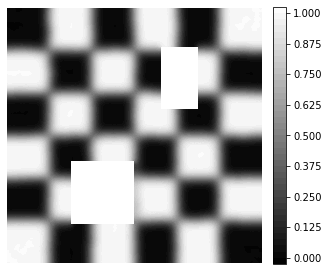

In [8]:
ic_func = checkerboard_function(num_checkers_x, num_checkers_y, Vh)
true_initial_condition = ic_func.vector()

utrue_initial = dl.Function(Vh)
utrue_initial.vector()[:] = true_initial_condition

cmap = 'gray' #'binary_r' #'gist_gray' #'binary' # 'afmhot'

plt.figure(figsize=(5,5))
cm = dl.plot(utrue_initial, cmap=cmap)
plt.axis('off')
plt.colorbar(cm,fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.show()

# Prior

In [9]:
prior_mean_func = dl.interpolate(dl.Constant(0.25), Vh)

# Mass matrix

In [10]:
M_petsc = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M_petsc)

M_scipy = nhf.csr_fenics2scipy(M_petsc)

def apply_M_numpy(x_numpy):
    return M_scipy @ x_numpy

def solve_M_numpy(x_numpy):
    x_petsc = dl.Function(Vh).vector()
    x_petsc[:] = x_numpy
    y_petsc = dl.Function(Vh).vector()
    M_solver.solve(y_petsc, x_petsc)
    return y_petsc[:]

mass_lumps = apply_M_numpy(np.ones(Vh.dim()))

apply_ML_numpy = lambda x: x * mass_lumps
solve_ML_numpy = lambda x: x / mass_lumps

# Forward problem and misfit

Number of observation points: 7863
AdvectionDiffusionMisfitStuff: kappa= 0.002 , t_final= 0.5
noise_norm= 0.7891679236502964


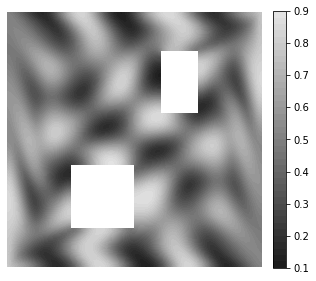

Text(0.5, 1.0, 'impulse response near [0.25 0.75]')

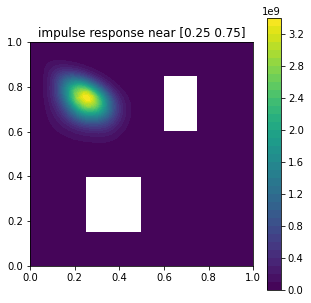

In [15]:
dt = 0.1
t_init = 0.
obs_coords = Vh.tabulate_dof_coordinates() # observe everywhere
print ("Number of observation points: {0}".format(obs_coords.shape[0]) )

class AdvectionDiffusionProblem:
    def __init__(me, kappa, t_final, gamma):
        print('AdvectionDiffusionMisfitStuff: kappa=', kappa, ', t_final=', t_final)
        me.kappa = kappa
        me.t_final = t_final
        me._gamma = gamma
        
        me.REG = BiLaplacianRegularization(me._gamma, prior_correlation_length, 
                                           dl.Function(Vh), prior_mean_func)
    
        me.simulation_times = np.arange(t_init, me.t_final+.5*dt, dt)
        me.observation_times = np.array([me.t_final])

        me.misfit = SpaceTimePointwiseStateObservation(Vh, 
                                                       me.observation_times, 
                                                       obs_coords)

        fake_gamma = 1.0
        fake_delta = 1.0

        fake_prior = BiLaplacianPrior(Vh, fake_gamma, fake_delta, robin_bc=True)
        
        me.problem = TimeDependentAD(mesh, [Vh,Vh,Vh], fake_prior, 
                                     me.misfit, me.simulation_times, 
                                     wind_velocity, True, kappa=me.kappa)
        
        me.utrue = me.problem.generate_vector(STATE)
        x = [me.utrue, true_initial_condition, None]
        me.problem.solveFwd(x[STATE], x)
        me.misfit.observe(x, me.misfit.d)

        me.true_obs_numpy = me.misfit.d.data[0][:].copy()

        MAX = me.misfit.d.norm("linf", "linf")
        noise_std_dev = rel_noise * MAX
        parRandom.normal_perturb(noise_std_dev, me.misfit.d)
        me.misfit.noise_variance = noise_std_dev*noise_std_dev

        me.obs_numpy = me.misfit.d.data[0][:].copy()

        me.noise_numpy = me.true_obs_numpy - me.obs_numpy
        me.noise_norm = np.linalg.norm(me.noise_numpy)
        print('noise_norm=', me.noise_norm)

        uf_petsc = dl.Function(Vh).vector()
        x[0].retrieve(uf_petsc, t_final)

        me.utrue_final = dl.Function(Vh)
        me.utrue_final.vector()[:] = uf_petsc
        
        me.H = ReducedHessian(me.problem, misfit_only=True)
        
        me.apply_Hr = me.REG.apply_hessian_petsc
        
    @property
    def gamma(me):
        return me._gamma
    
    def update_gamma(me, new_gamma):
        me._gamma = gamma
        me.REG.update_gamma(new_gamma)
        
    def eval_misfit_objective(me, m_petsc):
        [u,m,p] = me.problem.generate_vector()
        m[:] = m_petsc
        me.problem.solveFwd(u, [u,m,p])
        me.problem.solveAdj(p, [u,m,p])
        total_cost, reg_cost, misfit_cost = me.problem.cost([u,m,p])
        return misfit_cost
    
    def eval_misfit_gradient(me, m_petsc, return_gradnorm=False):
        [u,m,p] = me.problem.generate_vector()
        m[:] = m_petsc
        me.problem.solveFwd(u, [u,m,p])
        me.problem.solveAdj(p, [u,m,p])
        mg = me.problem.generate_vector(PARAMETER)
        grad_norm = me.problem.evalGradientParameter([u,m,p], mg, misfit_only=True)
        if return_gradnorm:
            return mg, grad_norm
        else:
            return mg

    def apply_Hd(me, x_petsc):
        y_petsc = dl.Function(Vh).vector()
        me.H.mult(x_petsc, y_petsc)
        return y_petsc
    
    def apply_Hd_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.apply_Hd(x_petsc)[:]
    
    def eval_regularization_objective(me, m_petsc):
        me.REG.parameter.vector()[:] = m_petsc
        return me.REG.cost()

    def eval_objective(me, m_petsc):
        return me.eval_misfit_objective(m_petsc) + me.eval_regularization_objective(m_petsc)
        
    def eval_regularization_gradient(me, m_petsc):
        me.REG.parameter.vector()[:] = m_petsc
        return me.REG.gradient_petsc()

    def eval_gradient(me, m_petsc):
        return me.eval_misfit_gradient(m_petsc) + me.eval_regularization_gradient(m_petsc)

    def apply_H(me, x_petsc):
        return me.apply_Hd(x_petsc) + me.apply_Hr(x_petsc)
    
    def apply_H_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.apply_H(x_petsc)[:]
    
    def apply_Hr_numpy(me, x_numpy):
        x_petsc = dl.Function(Vh).vector()
        x_petsc[:] = x_numpy
        return me.apply_Hr(x_petsc)[:]
    
    def get_impulse_response(me, k: int, lumped_mass=False
                            ) -> np.ndarray: # impulse response at kth dof location
        ek = np.zeros(Vh.dim())
        ek[k] = 1.0
        if lumped_mass:
            return solve_ML_numpy(me.apply_Hd_numpy(solve_ML_numpy(ek)))
        else:
            return solve_M_numpy(me.apply_Hd_numpy(solve_M_numpy(ek)))

ADP = AdvectionDiffusionProblem(kappa, t_final, gamma)

cmap = 'gray' #'binary_r' #'gist_gray' #'binary' # 'afmhot'

plt.figure(figsize=(5,5))
cm = dl.plot(ADP.utrue_final, cmap=cmap)
plt.axis('off')
cm.set_clim(0.0, 1.0)
# cm.extend = 'both'
plt.colorbar(cm, fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.show()

cmap = 'viridis'

plt.figure(figsize=(5,5))
p = np.array([0.25, 0.75])
impulse_response0 = dl.Function(Vh)
impulse_response0.vector()[:] = ADP.get_impulse_response(find_nearest_dof(p))
cm = dl.plot(impulse_response0, cmap=cmap)
plt.colorbar(cm)
plt.title('impulse response near ' + str(p))

# Gradient

In [22]:
m_petsc = dl.Function(Vh).vector()
mg = ADP.eval_gradient(m_petsc)
grad_norm = np.linalg.norm(mg[:])

print( "(g,g) = ", grad_norm)

(g,g) =  600437.2332752527


# Finite difference check

# Hessian

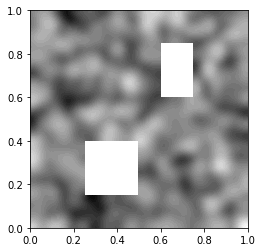

In [23]:
Vh_smoother = FenicsFunctionSmoother(Vh, smoothing_time=5e-4)
ms = Vh_smoother.random_smooth_function()
dl.plot(ms)

s= 1e-15 , err_grad= 1.0572190671694883 , err_hess= 0.9992962258969044
s= 1e-14 , err_grad= 1.5721906716948835 , err_hess= 0.9483635849791437
s= 1e-13 , err_grad= 0.2715348259886297 , err_hess= 0.30199055056004626
s= 1e-12 , err_grad= 0.01272685255731568 , err_hess= 0.031266057747410994
s= 1e-11 , err_grad= 0.001208524400495817 , err_hess= 0.003091450566755449
s= 1e-10 , err_grad= 0.0002459080410512357 , err_hess= 0.00030319709324233855
s= 1e-09 , err_grad= 9.912344579741474e-06 , err_hess= 3.092776852776117e-05
s= 1e-08 , err_grad= 1.173901821701489e-06 , err_hess= 2.9792030777884486e-06
s= 1e-07 , err_grad= 1.252989534595203e-07 , err_hess= 3.0990819718231005e-07
s= 1e-06 , err_grad= 6.496001126886894e-07 , err_hess= 3.081228133284016e-08
s= 1e-05 , err_grad= 6.414327612853855e-06 , err_hess= 3.2244954950274865e-09
s= 0.0001 , err_grad= 6.413805810399217e-05 , err_hess= 3.10968607968738e-10
s= 0.001 , err_grad= 0.0006417492089493038 , err_hess= 3.2480717901061096e-11
s= 0.01 , err_gr

Text(0.5, 1.0, 'hessian finite difference check')

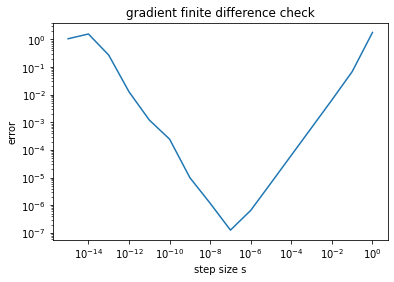

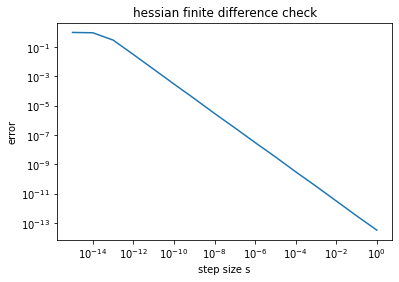

In [24]:
m0_petsc = Vh_smoother.random_smooth_function().vector()
J0 = ADP.eval_objective(m0_petsc)
G0 = ADP.eval_gradient(m0_petsc)

dm_petsc = Vh_smoother.random_smooth_function().vector()
H0_dm = ADP.apply_H(dm_petsc)

dJ = np.dot(G0[:], dm_petsc[:])

ss = np.logspace(-15,0,16)
grad_errors = []
hess_errors = []
for s in ss:
    m1_petsc = m0_petsc + s*dm_petsc
    J1 = ADP.eval_objective(m1_petsc)
    G1 = ADP.eval_gradient(m1_petsc)
    
    dJ_diff = (J1 - J0)/s
    err_grad = np.abs(dJ - dJ_diff) / np.linalg.norm(dJ_diff)
    grad_errors.append(err_grad)
    
    dG_diff = (G1 - G0)/s
    err_hess = np.linalg.norm(H0_dm - dG_diff) / np.linalg.norm(dG_diff)
    hess_errors.append(err_hess)
    
    print('s=', s, ', err_grad=', err_grad, ', err_hess=', err_hess)
    
plt.loglog(ss, grad_errors)
plt.xlabel('step size s')
plt.ylabel('error')
plt.title('gradient finite difference check')

plt.figure()
plt.loglog(ss, hess_errors)
plt.xlabel('step size s')
plt.ylabel('error')
plt.title('hessian finite difference check')

# Impulse responses for varying kappa

AdvectionDiffusionMisfitStuff: kappa= 0.01 , t_final= 0.5
noise_norm= 0.6047394645286364
AdvectionDiffusionMisfitStuff: kappa= 0.001 , t_final= 0.5
noise_norm= 0.8710048166056469
AdvectionDiffusionMisfitStuff: kappa= 0.0001 , t_final= 0.5
noise_norm= 1.0646949564757742


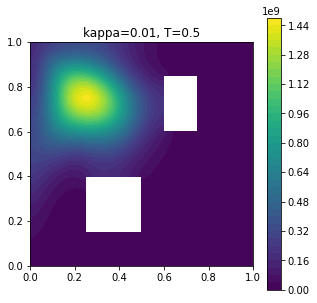

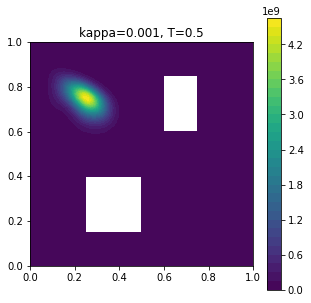

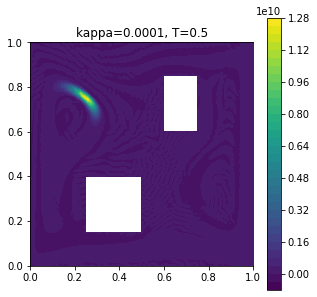

In [25]:
p = np.array([0.25, 0.75])

all_kappa = [1e-2, 1e-3, 1e-4]
tf_multikappa = 0.5

for kappa_prime in all_kappa:
    ADP = AdvectionDiffusionProblem(kappa_prime, tf_multikappa, gamma)
    plt.figure(figsize=(5,5))
    impulse_response0 = dl.Function(Vh)
    impulse_response0.vector()[:] = ADP.get_impulse_response(find_nearest_dof(p))
    cm = dl.plot(impulse_response0, cmap=cmap)
    plt.colorbar(cm)
    plt.title('kappa=' + str(kappa_prime) + ', T=' + str(tf_multikappa))

# Impulse responses for varying T

AdvectionDiffusionMisfitStuff: kappa= 0.0001 , t_final= 0.5
noise_norm= 1.0637268496909305
AdvectionDiffusionMisfitStuff: kappa= 0.0001 , t_final= 1.0
noise_norm= 1.0776777842635474
AdvectionDiffusionMisfitStuff: kappa= 0.0001 , t_final= 3.0
noise_norm= 0.8863251677066714


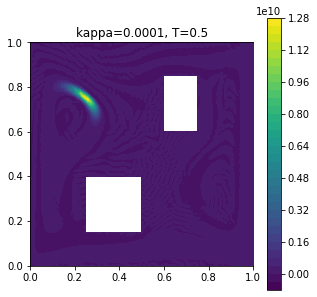

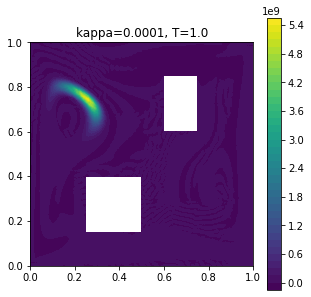

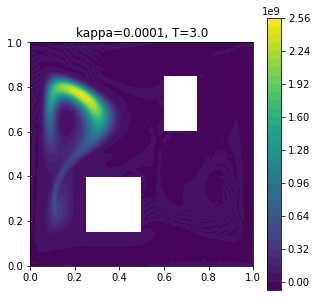

In [26]:
all_tf = [0.5, 1.0, 3.0]
kappa_multiT = 1e-4

for tf_prime in all_tf:
    ADP = AdvectionDiffusionProblem(kappa_multiT, tf_prime, gamma)
    plt.figure(figsize=(5,5))
    impulse_response0 = dl.Function(Vh)
    impulse_response0.vector()[:] = ADP.get_impulse_response(find_nearest_dof(p))
    cm = dl.plot(impulse_response0, cmap=cmap)
    plt.colorbar(cm)
    plt.title('kappa=' + str(kappa_multiT) + ', T=' + str(tf_prime))

# Krylov convergence and spectrum

In [47]:
ADP = AdvectionDiffusionProblem(kappa, t_final, gamma)

AdvectionDiffusionMisfitStuff: kappa= 0.002 , t_final= 0.5
noise_norm= 0.7904656088612824


# Build dense Hessian (brute force)

In [48]:
Hd_dense = nhf.build_dense_matrix_from_matvecs(ADP.apply_Hd_numpy,Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

In [49]:
Hr_dense = nhf.build_dense_matrix_from_matvecs(ADP.apply_Hr_numpy,Vh.dim())

  0%|          | 0/7862 [00:00<?, ?it/s]

# Solve for MAP point

In [50]:
def solve_inverse_problem(a_reg):
    H_dense = Hd_dense + a_reg*Hr_dense
    g0_numpy = ADP.eval_gradient(dl.Function(Vh).vector())[:]

    m_star = np.linalg.solve(H_dense, -g0_numpy)
    return m_star

def compute_morozov_discrepancy(m_star_numpy):
    m_star = dl.Function(Vh).vector()
    m_star[:] = m_star_numpy
    u_star = ADP.problem.generate_vector(STATE)
    x = [u_star, m_star, None]
    ADP.problem.solveFwd(x[STATE], x)
    new_obs = ADP.misfit.d.copy()
    new_obs.zero()
    ADP.misfit.observe(x, new_obs)
    return np.linalg.norm(new_obs.data[0][:] - ADP.obs_numpy)

In [51]:
a_reg_morozov = compute_morozov_regularization_parameter(solve_inverse_problem,
                                                         compute_morozov_discrepancy,
                                                         ADP.noise_norm,
                                                         a_reg_min=1e-2, a_reg_max=1e2,
                                                         rtol=1e-2)
print('a_reg_morozov=', a_reg_morozov)

Computing regularization parameter via Morozov discrepancy principle
a_reg= 0.010000000000000004 , morozov discrepancy= 0.9347289158653839 , noise level= 0.7904656088612824


KeyboardInterrupt: 

a_reg_morozov= 2.106889762401201 , noise_norm= 0.7893603890040852 , mzd= 0.7893639270111009


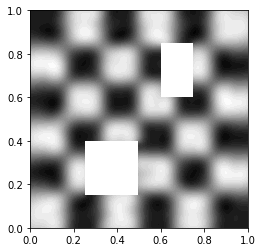

In [33]:
m_star = solve_inverse_problem(a_reg_morozov)
m_MAP = dl.Function(Vh)
m_MAP.vector()[:] = m_star
dl.plot(m_MAP)

mzd = compute_morozov_discrepancy(m_star)
print('a_reg_morozov=', a_reg_morozov, ', noise_norm=', noise_norm, ', mzd=', mzd)

# Build Hmatrix approximations

In [ ]:
num_batches = 20
tau = 3.0
num_neighbors = 10

PCK = ProductConvolutionKernel(Vh, Vh, 
                               apply_misfit_gauss_newton_hessian_petsc, 
                               apply_misfit_gauss_newton_hessian_petsc,
                               num_batches, num_batches,
                               tau_rows=tau, tau_cols=tau,
                               num_neighbors_rows=num_neighbors,
                               num_neighbors_cols=num_neighbors)

In [ ]:
raise RuntimeError

# Compute spectra

In [ ]:
H_dense = Hd_dense + a_reg_morozov*Hr_dense

evals_REG, evecs_REG = sla.eigh(H_dense, a_reg_morozov*Hr_dense)

Text(0.5, 1.0, 'Regularization preconditioned misfit Hessian eigenvalues')

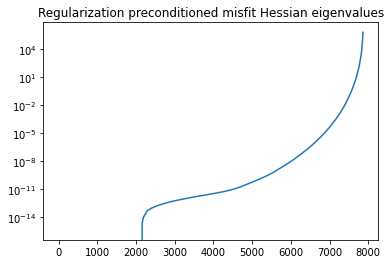

In [36]:
plt.semilogy(evals_REG - 1.0)
plt.title('Regularization preconditioned misfit Hessian eigenvalues')

Text(0.5, 1.0, 'Misfit Hessian eigenvalues')

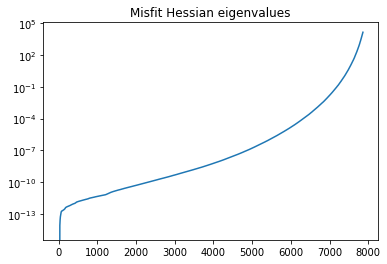

In [26]:
evals_NONE, evecs_NONE = sla.eigh(Hd_dense)

plt.semilogy(evals_NONE)
plt.title('Misfit Hessian eigenvalues')

In [38]:
g0_numpy = eval_gradient(dl.Function(Vh).vector())[:]

H_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=apply_H_numpy)

# p, info = spla.cg(H_linop, -g0)
result_NONE = nhf.custom_cg(H_linop, -g0_numpy, x_true=m_star, maxiter=1000, display=True, tol=1e-13)
p_true = result_NONE[0]

solve_Hr_linop = spla.LinearOperator((Vh.dim(), Vh.dim()), matvec=REG.solve_R_numpy)

result_REG = nhf.custom_cg(H_linop, -g0_numpy, x_true=m_star, M=solve_Hr_linop, maxiter=1000, display=True, tol=1e-13)

k=0, res=0.22011206862780225, err=0.5303878188988942
k=1, res=0.11429959996054702, err=0.45971039098509753
k=2, res=0.09350571514161896, err=0.3726397894943674
k=3, res=0.041903936576430253, err=0.336112306614519
k=4, res=0.03293659364723691, err=0.316040538040448
k=5, res=0.024740372249091497, err=0.2938821654911822
k=6, res=0.017602858742378196, err=0.2787574490042068
k=7, res=0.01680398401783641, err=0.26239011172006244
k=8, res=0.012710742198317127, err=0.2485645130424165
k=9, res=0.010122840897826745, err=0.23815244792894832
k=10, res=0.009093714730603912, err=0.22824753701758077
k=11, res=0.008014115549785969, err=0.21813832328727858
k=12, res=0.006827076327233087, err=0.20811654741036523
k=13, res=0.006293604282930342, err=0.1994241613066421
k=14, res=0.0056327453628629825, err=0.1908619023628568
k=15, res=0.004972003537051079, err=0.18255055272438378
k=16, res=0.004228467130800256, err=0.17593802814113627
k=17, res=0.0037955782714567676, err=0.16986517548942545
k=18, res=0.0033

k=145, res=2.7300496833571855e-05, err=0.022783397677928873
k=146, res=2.680299828915723e-05, err=0.022758893963858103
k=147, res=2.5915474064248914e-05, err=0.022736300828015955
k=148, res=2.520439321365707e-05, err=0.02271621642464058
k=149, res=2.489378005502581e-05, err=0.02269959609590298
k=150, res=2.3358758292408336e-05, err=0.022685097785528855
k=151, res=2.1922197184335664e-05, err=0.022669545376922225
k=152, res=2.1129981531304395e-05, err=0.022655014031770736
k=153, res=2.0455723844877056e-05, err=0.022641853926949233
k=154, res=1.8928027736664215e-05, err=0.02263010025737413
k=155, res=1.8008349766100835e-05, err=0.022618947811979578
k=156, res=1.777645448688433e-05, err=0.022608273088491577
k=157, res=1.8030502180827414e-05, err=0.022599091021506836
k=158, res=1.7569026496636686e-05, err=0.022591048003910912
k=159, res=1.657560511805102e-05, err=0.02258235627379933
k=160, res=1.6418925378694426e-05, err=0.022573744250756266
k=161, res=1.6682186205779014e-05, err=0.02256532

k=289, res=6.795878329052777e-07, err=0.022254418926671488
k=290, res=6.290824652218968e-07, err=0.022254113569418785
k=291, res=6.303017657262007e-07, err=0.022253813944973715
k=292, res=6.480494671809097e-07, err=0.02225355162488915
k=293, res=6.22817524006845e-07, err=0.022253336119138066
k=294, res=5.948302186315006e-07, err=0.022253120164839896
k=295, res=5.672212397899054e-07, err=0.022252916730098927
k=296, res=5.846710354178669e-07, err=0.022252737719372813
k=297, res=5.4318853650423e-07, err=0.022252584567961826
k=298, res=5.177646306448246e-07, err=0.022252428776875194
k=299, res=4.860665701372843e-07, err=0.02225229129765721
k=300, res=4.7158503414058877e-07, err=0.02225217398768184
k=301, res=4.6216158954182363e-07, err=0.022252074622360885
k=302, res=4.6189981226066246e-07, err=0.022251990598556533
k=303, res=4.56614086585753e-07, err=0.022251923404877614
k=304, res=4.4103106961833663e-07, err=0.022251869165836758
k=305, res=4.30924170317595e-07, err=0.02225182895790768
k=

k=433, res=1.652204728652128e-08, err=0.022258765736013514
k=434, res=1.5231329534188688e-08, err=0.02225876170710081
k=435, res=1.5040286058178186e-08, err=0.022258757632496743
k=436, res=1.4830691953417436e-08, err=0.022258754316601327
k=437, res=1.4275571125379915e-08, err=0.02225875127710333
k=438, res=1.4359926981031257e-08, err=0.022258748546725597
k=439, res=1.4225169697261592e-08, err=0.022258746186689236
k=440, res=1.377323995830504e-08, err=0.0222587442183038
k=441, res=1.2603473632009933e-08, err=0.02225874230465563
k=442, res=1.3389409110813282e-08, err=0.022258740677218163
k=443, res=1.3052962550373e-08, err=0.022258739502112355
k=444, res=1.192191877017471e-08, err=0.022258738337321386
k=445, res=1.144723443054537e-08, err=0.022258737289507526
k=446, res=1.2034109513807916e-08, err=0.022258736547395897
k=447, res=1.2103935857820404e-08, err=0.02225873611280193
k=448, res=1.0816055043455674e-08, err=0.022258735773151135
k=449, res=1.0212151028492199e-08, err=0.022258735613

k=577, res=3.763320503242552e-10, err=0.022258873773620708
k=578, res=3.9557681842620947e-10, err=0.022258873719803538
k=579, res=3.852116169408738e-10, err=0.022258873662645833
k=580, res=3.501145586673645e-10, err=0.02225887359287811
k=581, res=3.4759246196353035e-10, err=0.022258873514867997
k=582, res=3.5598976634499574e-10, err=0.022258873441582738
k=583, res=3.4442774715192665e-10, err=0.022258873372602506
k=584, res=3.3210952517292067e-10, err=0.022258873302269985
k=585, res=3.132105347178672e-10, err=0.022258873227065913
k=586, res=3.2091396734151175e-10, err=0.02225887315583926
k=587, res=2.909509328380622e-10, err=0.022258873075976512
k=588, res=2.7360389798839903e-10, err=0.02225887298678038
k=589, res=2.6958485833659645e-10, err=0.022258872893000627
k=590, res=2.734390381631885e-10, err=0.02225887280130617
k=591, res=2.772023410099104e-10, err=0.02225887271859291
k=592, res=2.492225340232678e-10, err=0.022258872635364572
k=593, res=2.4284550072209435e-10, err=0.022258872548

k=721, res=4.937182462382682e-12, err=0.02225887100649523
k=722, res=5.437019412408239e-12, err=0.022258871008187665
k=723, res=4.873795408465638e-12, err=0.022258871009527895
k=724, res=4.442990291924518e-12, err=0.022258871011027564
k=725, res=4.1626704254015085e-12, err=0.02225887101252632
k=726, res=4.2472010917372676e-12, err=0.022258871013847336
k=727, res=4.2668760237037836e-12, err=0.02225887101498206
k=728, res=4.2826962021747274e-12, err=0.022258871016039912
k=729, res=4.148873034473681e-12, err=0.022258871017024798
k=730, res=3.9242807818576774e-12, err=0.022258871018074857
k=731, res=3.658872854493904e-12, err=0.022258871019097824
k=732, res=3.5061967385499485e-12, err=0.022258871020051935
k=733, res=3.5607836955115603e-12, err=0.02225887102086087
k=734, res=3.4187546491377975e-12, err=0.022258871021615795
k=735, res=3.1987421738105868e-12, err=0.022258871022332646
k=736, res=3.183089660565198e-12, err=0.022258871022997347
k=737, res=3.1400537705507145e-12, err=0.0222588710

k=1, res=0.1874283829166283, err=0.5959947798965132
k=2, res=0.1785646744062533, err=0.5805555780848972
k=3, res=0.16760177361568918, err=0.551105219091025
k=4, res=0.14694066048639623, err=0.5166097000764649
k=5, res=0.1378218720201258, err=0.4746955525403306
k=6, res=0.11954671534191989, err=0.43426293152811024
k=7, res=0.10035856182483714, err=0.4028279280317846
k=8, res=0.08532902505479235, err=0.37009595502387843
k=9, res=0.0756113575168769, err=0.35096184615448833
k=10, res=0.06851986966528646, err=0.320019664861908
k=11, res=0.06204964566137448, err=0.2887708516774058
k=12, res=0.051817607415415114, err=0.26056824820465796
k=13, res=0.036629460197632184, err=0.2280527950632849
k=14, res=0.031959557834710765, err=0.21391282238800088
k=15, res=0.027723099432414522, err=0.20428876380243333
k=16, res=0.02449608418230133, err=0.19763544530458466
k=17, res=0.02209724300913175, err=0.18966995411697182
k=18, res=0.021500011978082517, err=0.17369659673478063
k=19, res=0.02167272360356947

k=147, res=0.0009071908416508689, err=0.04237421481882954
k=148, res=0.0008811760556378412, err=0.041451767298073434
k=149, res=0.0008592006420007117, err=0.041273581940582095
k=150, res=0.0008060374945646967, err=0.04101726434942664
k=151, res=0.0007973168213388378, err=0.040974726446982565
k=152, res=0.0008118288878212772, err=0.04090999024985462
k=153, res=0.0009183850620889377, err=0.040333044909311125
k=154, res=0.0008672136596605505, err=0.03929638526970944
k=155, res=0.0007630027374811697, err=0.03895558459412921
k=156, res=0.0007539031121973504, err=0.03888289270302018
k=157, res=0.0007595144415734154, err=0.038822255331705476
k=158, res=0.0007644655153634087, err=0.03844993137314086
k=159, res=0.0007695891923155104, err=0.038428831196140614
k=160, res=0.0007659394378982216, err=0.03747404828289586
k=161, res=0.0007221002539727506, err=0.03712585547402601
k=162, res=0.0007874370975839299, err=0.036662613170090445
k=163, res=0.0007599125729388577, err=0.036473051863540155
k=164,

k=290, res=0.0004333386977301782, err=0.01817529115231437
k=291, res=0.0004446444693075523, err=0.018258368916536018
k=292, res=0.0004123147542664712, err=0.018336977816206832
k=293, res=0.0004093603574362469, err=0.018348886682070274
k=294, res=0.0004081219305764031, err=0.01835313837898661
k=295, res=0.0004093545580948996, err=0.018358772802813957
k=296, res=0.0004079656884508394, err=0.01836098715026579
k=297, res=0.00041407018918689884, err=0.018371889902642123
k=298, res=0.0004126313067968049, err=0.018442690459099916
k=299, res=0.00041234406723161056, err=0.01844851428834914
k=300, res=0.000404431330987811, err=0.018501688774498787
k=301, res=0.00040357070720817805, err=0.01853340940118865
k=302, res=0.0003956101072971317, err=0.018551744661483557
k=303, res=0.000395837197150648, err=0.018552156411284142
k=304, res=0.00039772482212039267, err=0.018554607660327446
k=305, res=0.0003985290614214682, err=0.018554640048430295
k=306, res=0.00039517768541977023, err=0.018653191322906992

k=430, res=0.0002476662101337296, err=0.021397232711804434
k=431, res=0.00024823188409803574, err=0.021397621853469707
k=432, res=0.0002482919677260085, err=0.021398008287559347
k=433, res=0.0002507840549274291, err=0.021428931435564885
k=434, res=0.00025113354901643383, err=0.021432652887763453
k=435, res=0.0002528825871450104, err=0.021458044160272135
k=436, res=0.00023458351026326506, err=0.021594025310158922
k=437, res=0.00023372188794151244, err=0.021600883283133317
k=438, res=0.00023181132775875298, err=0.021604843835674244
k=439, res=0.00023354880297595337, err=0.021616030055036192
k=440, res=0.00023140795450206413, err=0.02163018560525123
k=441, res=0.00023342570081584342, err=0.021659934119661866
k=442, res=0.00023246791487205933, err=0.021663584562123493
k=443, res=0.000233492572834453, err=0.02167908690269848
k=444, res=0.00023160936630736072, err=0.02168413236056624
k=445, res=0.0002323727918462577, err=0.02169442922244192
k=446, res=0.000230257397928145, err=0.021699688679

k=572, res=9.686286888414596e-05, err=0.022868625857138065
k=573, res=9.657753735429238e-05, err=0.0228688079555308
k=574, res=9.471206942172706e-05, err=0.022871018943618416
k=575, res=9.307471427059303e-05, err=0.02287163786691855
k=576, res=9.299065460488611e-05, err=0.022871739513861185
k=577, res=9.209211930974776e-05, err=0.022871981392064117
k=578, res=9.19298740928824e-05, err=0.022871963812251622
k=579, res=9.207066593064126e-05, err=0.02287221425762266
k=580, res=9.044563217264333e-05, err=0.022872172015072762
k=581, res=9.038222918487801e-05, err=0.022872136872904847
k=582, res=9.215270381967856e-05, err=0.022871536636645217
k=583, res=9.189820204612939e-05, err=0.022871782401353798
k=584, res=9.19370991426578e-05, err=0.022872326206513645
k=585, res=8.737251074753792e-05, err=0.022875083516551268
k=586, res=8.776750328106591e-05, err=0.022875580131982844
k=587, res=8.801997549678246e-05, err=0.022876086242935856
k=588, res=8.562071149941727e-05, err=0.022878459560844555
k=5

k=713, res=3.318135606786815e-05, err=0.022620859462656517
k=714, res=3.115532115288609e-05, err=0.022616605179744335
k=715, res=3.030177558488953e-05, err=0.022615899175223275
k=716, res=3.0799616978044034e-05, err=0.022614734280961248
k=717, res=3.106010963184463e-05, err=0.022611337419496096
k=718, res=2.8687607781784802e-05, err=0.022598149325092635
k=719, res=2.8289497354984487e-05, err=0.02259780352174065
k=720, res=2.8471630257253073e-05, err=0.022597230536795403
k=721, res=2.744830148687039e-05, err=0.022593408224785318
k=722, res=2.732795901681921e-05, err=0.022593236147403918
k=723, res=2.7276125262915604e-05, err=0.022592033490033785
k=724, res=2.6545656471837378e-05, err=0.022590906403046188
k=725, res=2.6542595477724304e-05, err=0.022590878682818706
k=726, res=2.712448388096409e-05, err=0.022588492633132833
k=727, res=2.689592519829052e-05, err=0.022586442791441317
k=728, res=2.8131222412359155e-05, err=0.02258023408041992
k=729, res=2.8408355932829047e-05, err=0.022578665

k=854, res=7.370935844883351e-06, err=0.0223892831528608
k=855, res=7.366524180392909e-06, err=0.022389251702495058
k=856, res=7.518447308455092e-06, err=0.022388957975783413
k=857, res=7.133745293939802e-06, err=0.022387094810538476
k=858, res=7.117227656532447e-06, err=0.02238705070640442
k=859, res=7.212695082278295e-06, err=0.022386489178592026
k=860, res=7.2446476823488505e-06, err=0.022386233765028487
k=861, res=7.257666658541177e-06, err=0.022385755531516043
k=862, res=7.123592892140804e-06, err=0.022385621366631338
k=863, res=7.077930181742226e-06, err=0.022385531926236824
k=864, res=7.113179520782193e-06, err=0.022385474555690805
k=865, res=7.2914850354688594e-06, err=0.022385230043818614
k=866, res=7.076867416265392e-06, err=0.022384189368282775
k=867, res=7.093936452160231e-06, err=0.02238416347788695
k=868, res=7.122343989114892e-06, err=0.022374981428728537
k=869, res=7.020692899091214e-06, err=0.02237468707611896
k=870, res=6.627924754581039e-06, err=0.022374016404113167


k=995, res=2.3467960512525716e-06, err=0.02229781923463853
k=996, res=2.3550736386855863e-06, err=0.022297744135457098
k=997, res=2.322563093478403e-06, err=0.022297620143193125
k=998, res=2.2621822624391416e-06, err=0.022297145207637155
k=999, res=2.328705533131494e-06, err=0.022297032214198893


NameError: name 'result' is not defined

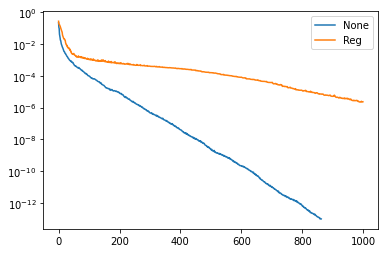

In [43]:
plt.semilogy(result_NONE[2])
plt.semilogy(result_REG[2])
plt.legend(['None', 'Reg'])

## 8. The Gaussian posterior

In [ ]:
k = 150
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, fake_prior.R, fake_prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( fake_prior, lmbda, V )

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])

## 9. Compute the MAP point

In [ ]:
H.misfit_only = False

[u,m,p] = problem.generate_vector()

solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( posterior.Hlr )
solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6
solver.solve(m, -mg)
problem.solveFwd(u, [u,m,p])
 
total_cost, reg_cost, misfit_cost = problem.cost([u,m,p])
print( "Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost) )
    
posterior.mean = m

plt.figure(figsize=(7.5,5))
nb.plot(dl.Function(Vh, m), mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution")

## 10. Prior and posterior pointwise variance fields

In [ ]:
compute_trace = False
# compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()

## 11. Draw samples from the prior and posterior distributions

In [ ]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")
s_prior = dl.Function(Vh, name="sample_prior")
s_post = dl.Function(Vh, name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + fake_prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + fake_prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    parRandom.normal(1., noise)
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=pr_min, vmax=pr_max)
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=ps_min, vmax=ps_max)
    plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright (c) 2019-2020, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.

In [ ]:
H.misfit_only = True

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
x_fct.vector()[:] = np.random.randn(Vh.dim())
H.mult(x_fct.vector(), y_fct.vector())

cm = dl.plot(x_fct)
plt.colorbar(cm)
plt.title('x')

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
# plt.plot(targets[:,0], targets[:,1], '*r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 500
# k = 1000

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

cm = dl.plot(x_fct)
plt.colorbar(cm)
plt.title('x')

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '*r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = 500
k = 1000

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '*r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 1002

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 4300

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [2]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 5710

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

NameError: name 'dl' is not defined

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = 6610

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(0.75*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

k = int(np.random.rand()*Vh.dim())

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

M_solver.solve(x_fct.vector(), x_dual_vec)

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
# M_solver.solve(y_fct.vector(), y_dual_vec)
y_fct.vector()[:] = y_dual_vec

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

y_dual_vec = dl.Function(Vh).vector()

x_fct.vector()[:] = 1.0

H.misfit_only = True
H.mult(x_fct.vector(), y_dual_vec)
M_solver.solve(y_fct.vector(), y_dual_vec)
# y_fct.vector()[:] = y_dual_vec

plt.figure()
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

In [ ]:
# raise RuntimeError('Stop here')

In [3]:
# from nalger_helper_functions import *

import hlibpro_python_wrapper as hpro
from localpsf.product_convolution_kernel import ProductConvolutionKernel
from localpsf.product_convolution_hmatrix import make_hmatrix_from_kernel

ImportError: initialization failed

In [ ]:
def apply_misfit_gauss_newton_hessian_petsc(x_petsc): # Hd_gn * x = y
    H.misfit_only = True
    y_petsc = dl.Function(Vh).vector()
    H.mult(x_petsc, y_petsc)
    return y_petsc

num_batches = 20
tau = 3.0
num_neighbors = 10

PCK = ProductConvolutionKernel(Vh, Vh, 
                               apply_misfit_gauss_newton_hessian_petsc, 
                               apply_misfit_gauss_newton_hessian_petsc,
                               num_batches, num_batches,
                               tau_rows=tau, tau_cols=tau,
                               num_neighbors_rows=num_neighbors,
                               num_neighbors_cols=num_neighbors)

In [ ]:
for k in range(PCK.col_batches.num_batches):
    PCK.col_batches.visualize_impulse_response_batch(k)

In [ ]:
hmatrix_tol=1e-6
Hd_pch_nonsym, extras = make_hmatrix_from_kernel(PCK, hmatrix_tol=hmatrix_tol)
# Hd_pch = Hd_pch_nonsym.spd()

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
y_fct_pch = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_fct.vector())
y_fct_pch.vector()[:] = Hd_pch_nonsym * x_fct.vector()[:]
# M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

plt.subplot(1,2,2)
cm = dl.plot(y_fct_pch)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')


In [ ]:
Hd_pch = Hd_pch_nonsym.spd(rtol=1e-6,k=2,a_factor=2)

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
y_fct_pch = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_fct.vector())
y_fct_pch.vector()[:] = Hd_pch.matvec(x_fct.vector()[:])
# M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

plt.subplot(1,2,2)
cm = dl.plot(y_fct_pch)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')

sum_true = np.sum(y_fct.vector()[:])
sum_pch = np.sum(y_fct_pch.vector()[:])
print('sum_true=', sum_true, ', sum_pch=', sum_pch, ', sum_true/sum_pch=', sum_true/sum_pch)

In [ ]:
raise RuntimeError

In [ ]:
# from tqdm.auto import tqdm

# Hdense = np.zeros((Vh.dim(), Vh.dim()))
# for k in tqdm(range(Hdense.shape[1])):
#     ek = np.zeros(Vh.dim())
#     ek[k] = 1.0
#     Hdense[:,k] = Hd_pch_nonsym * ek

In [ ]:
# Hdense_sym = 0.5*(Hdense + Hdense.T)

In [ ]:
# ee, P = np.linalg.eigh(Hdense_sym)

In [ ]:
# plt.plot(ee)

# plt.figure()
# plt.plot(ee[:100])

In [ ]:
# # Hdense_plus = np.dot(P, np.dot(np.diag(np.abs(ee)), np.linalg.inv(P)))
# Hdense_plus = np.dot(P, np.dot(np.diag(ee*(ee>0)), np.linalg.inv(P)))

In [ ]:
# M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
# M_solver = dl.LUSolver(M)

# # k = int(np.random.rand()*Vh.dim())
# # k = good_inds[int(np.random.rand()*len(good_inds))]

# p = np.random.rand(2)
# # p = np.array([0., 1.])
# # p = np.array([0.5, 0.5])
# # p = p + [0.05, -0.05]
# # p = p + [-0.05, 0.0]
# k = dof_kdt.query(p)[1]

# x_dual_vec = dl.Function(Vh).vector()
# y_dual_vec = dl.Function(Vh).vector()

# x_dual_vec[k] = 1.0

# x_fct = dl.Function(Vh)
# y_fct = dl.Function(Vh)
# y_fct_pch = dl.Function(Vh)
# y_fct_plus = dl.Function(Vh)

# # M_solver.solve(x_fct.vector(), x_dual_vec)
# x_fct.vector()[:] = x_dual_vec

# H.misfit_only = True
# H.mult(x_fct.vector(), y_fct.vector())
# y_fct_plus.vector()[:] = Hdense_plus @ x_fct.vector()[:]
# y_fct_pch.vector()[:] = Hd_pch_nonsym * x_fct.vector()[:]
# # M_solver.solve(y_fct.vector(), y_dual_vec)


# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# cm = dl.plot(y_fct)
# plt.colorbar(cm)
# plt.title('y')
# plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# # plt.plot(targets[:,0], targets[:,1], '.r')

# plt.subplot(1,3,2)
# cm = dl.plot(y_fct_pch)
# plt.colorbar(cm)
# plt.title('y')
# plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')

# plt.subplot(1,3,3)
# cm = dl.plot(y_fct_plus)
# plt.colorbar(cm)
# plt.title('y')
# plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')


In [ ]:
Hd_pch_nonsym.visualize('adv_nonsym2')

In [ ]:
Hd_pch_sym = Hd_pch_nonsym.sym()

In [ ]:
Hd_pch_sym.visualize('adv_sym2')

In [ ]:
ee_SA, _ = spla.eigsh(Hd_pch_sym.as_linear_operator(), k=1, which='SA')
lambda_min = np.min(ee_SA)

In [ ]:
lambda_min

In [ ]:
a_factor=2.0
b_factor=0.0
k=1

a = a_factor * lambda_min
b = b_factor * lambda_min

scaling_at_lambda_min = 1. / (1.0 + ((2.0*lambda_min - (b + a)) / (b - a)) ** (2 ** k))
print('scaling_at_lambda_min=', scaling_at_lambda_min)

scaling_at_zero = 1. / (1.0 + (-(b+a)/(b-a))**(2**k))
print('scaling_at_zero=', scaling_at_zero)

In [ ]:
T = Hd_pch_sym.copy()
T = (T * 2.0).add_identity(s=-(b + a)) * (1.0 / (b - a))

In [ ]:
T.visualize('T0')

In [ ]:
T1 = hpro.h_mul(T, T, rtol=1e-6, atol=1e-10, display_progress=True)

In [ ]:
T1.visualize('T1')

In [ ]:
T1 = T1.sym()
T1.visualize('T1 (sym)')

In [ ]:
T1b = T1.add_identity()

In [ ]:
iT1b = T1b.factorized_inverse(rtol=1e-6, atol=1e-10)

In [ ]:
M = dl.assemble(dl.TestFunction(Vh) * dl.TrialFunction(Vh) * dl.dx)
M_solver = dl.LUSolver(M)

# k = int(np.random.rand()*Vh.dim())
# k = good_inds[int(np.random.rand()*len(good_inds))]

p = np.random.rand(2)
# p = np.array([0., 1.])
# p = np.array([0.5, 0.5])
# p = p + [0.05, -0.05]
# p = p + [-0.05, 0.0]
k = dof_kdt.query(p)[1]

x_dual_vec = dl.Function(Vh).vector()
y_dual_vec = dl.Function(Vh).vector()

x_dual_vec[k] = 1.0

x_fct = dl.Function(Vh)
y_fct = dl.Function(Vh)
y_fct_pch = dl.Function(Vh)

# M_solver.solve(x_fct.vector(), x_dual_vec)
x_fct.vector()[:] = x_dual_vec

H.misfit_only = True
H.mult(x_fct.vector(), y_fct.vector())
y_fct_pch.vector()[:] = Hd_pch_sym.matvec(x_fct.vector()[:] - 2.0 * iT1b.matvec( x_fct.vector()[:]))
# M_solver.solve(y_fct.vector(), y_dual_vec)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cm = dl.plot(y_fct)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')
# plt.plot(targets[:,0], targets[:,1], '.r')

plt.subplot(1,2,2)
cm = dl.plot(y_fct_pch)
plt.colorbar(cm)
plt.title('y')
plt.plot(dof_coords[k,0], dof_coords[k,1], '.k')


In [ ]:
raise RuntimeError

In [ ]:
raise RuntimeError

In [ ]:
raise RuntimeError

In [ ]:
iT1b = T1b.inv(rtol=1e-6, atol=1e-10)

In [ ]:
raise RuntimeError

In [ ]:
iHHH = Hd_pch_sym.add_identity(s=3000.0).inv(rtol=1e-6,atol=1e-10,display_progress=False)

In [ ]:
inv_options = hpro.hpro_cpp.fac_options_t()

In [ ]:
cpp_diag_type = hpro.hpro_cpp.diag_type_t.general_diag
cpp_storage_type = hpro.hpro_cpp.storage_type_t.store_normal
do_coarsen=False

In [ ]:
inv_options = hpro.hpro_cpp.inv_options_t(cpp_diag_type, cpp_storage_type, do_coarsen, None)

In [ ]:
acc = hpro.hpro_cpp.TTruncAcc(relative_eps=1e-6, absolute_eps=1e-10)

In [ ]:
inverse_cpp_object = hpro.hpro_cpp.copy_TMatrix(Hd_pch_sym.add_identity(s=3000.0).cpp_object)

In [ ]:
hpro.hpro_cpp.invert_h_matrix(inverse_cpp_object, acc, inv_options)

In [ ]:
raise RuntimeError

In [ ]:
ee_T1b, _ = spla.eigsh(T1b.as_linear_operator(), k=1, which='LA')
lambda_max_T1b = np.max(ee_T1b)
print('lambda_max_T1b=', lambda_max_T1b)

In [ ]:
ee_T1b, _ = spla.eigsh(T1b.as_linear_operator(), k=1, which='SA')
lambda_min_T1b = np.min(ee_T1b)
print('lambda_min_T1b=', lambda_min_T1b)

In [ ]:
# Schulz iteration
rtol=1e-6
atol=1e-10

A = T1b * (1./(2*lambda_max_T1b))
X = A

In [ ]:
Z1 = hpro.h_mul(A, X, rtol=rtol, atol=atol, display_progress=True)

In [ ]:
Z2 = ((-1.0)*Z1).add_identity(s=2.0)

In [ ]:
Z3 = hpro.h_mul(X, Z2, rtol=rtol, atol=atol, display_progress=True)

In [ ]:
x = np.random.randn(Z3.shape[1])
x2 = Z3 * (A * x)

In [ ]:
x

In [ ]:
x2

In [ ]:
plt.plot(x)
plt.plot(x2)

In [ ]:
raise RuntimeError

In [ ]:
Pi_minus = T1b.sym().inv(rtol=1e-6, atol=1e-10, display_progress=True)

In [ ]:
raise RuntimeError

In [ ]:
Pi_minus = T1.add_identity(s=10.0).inv(rtol=1e-6, atol=1e-10, display_progress=True)

In [ ]:
3

In [ ]:
Hd_pch_deflated = hpro.rational_positive_definite_approximation_low_rank_method(Hd_pch_nonsym, cutoff=-500.0,
                                                         block_size=20,
                                                         max_rank=500,
                                                         display=True,
                                                         overwrite=False,
                                                         rtol=1e-6,
                                                         atol=1e-12)

In [ ]:
Vh.dim()

In [ ]:
Hd_pch_deflated.spd(rtol=1e-5, k=1)